### Using RGDR
This notebook outlines the current status of the RGDR implementation.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import lilio
from s2spy import RGDR

First we will load in some example data, and resample them using `lilio`'s `Calendar`.

In [2]:
file_path = '../../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

Create calendar, map it to dataset and visualize it.

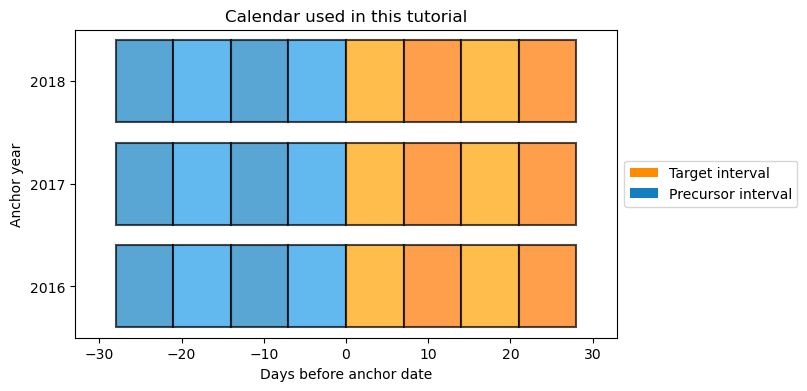

In [3]:
cal = lilio.Calendar(anchor="08-01")
cal.add_intervals("target", length="1W", n=4)
cal.add_intervals("precursor", length="1W", n=4)

cal = cal.map_to_data(field)
cal.visualize(n_years=3, relative_dates=True)
_ = plt.title("Calendar used in this tutorial")

Resample data with calendar.

In [4]:
field_resampled: xr.Dataset = lilio.resample(cal, field)
target_resampled: xr.Dataset = lilio.resample(cal, target)

### The target timeseries comes from already pre-clustered land surface temperature data.
RGDR requires `DataArray`s as input, as otherwise it is ambiguous which variable should be used.

When initializing RGDR, the target interval(s) and lag have to be specified as well.
The precursor interval(s) will be determined from the target intervals and lag.
The maximum possible lag will depend on the number of available precursor intervals.

In the illustration you see the algorithm that is used to calculate the correlation in RGDR, when you specify a single target interval:

![Single target](../notebooks/single_target_RGDR.svg)

Below we use the first target interval, and a lag of `4`. This makes the precursor interval index `-4`. An example with multiple targets follows later.

In [5]:
target_timeseries = target_resampled.sel(cluster=3)["ts"]
precursor_field = field_resampled["sst"]

target_intervals = 1
lag = 4
rgdr = RGDR(
    target_intervals=target_intervals,
    lag=lag,
    eps_km=600,
    alpha=0.05,
    min_area_km2=0
)
rgdr.precursor_intervals

[-4]

Using `.preview_correlation` we can visualize the correlation and p-value map of the target timeseries and precursor field.

The red hashing shows where p-value `<` alpha

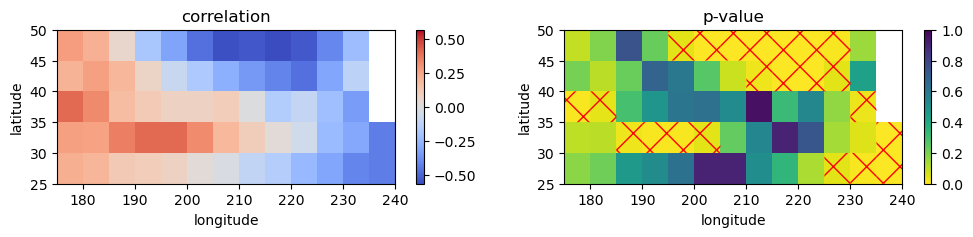

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))
_ = rgdr.preview_correlation(precursor_field, target_timeseries, ax1=ax1, ax2=ax2)
rgdr.fit(precursor_field, target_timeseries)

Using the preview utilities we can compare two RGDR setups, and see what the effect on the generated clusters will be.

Note that the second figure has an extra cluster, due to the minimum area argument having a smaller value.

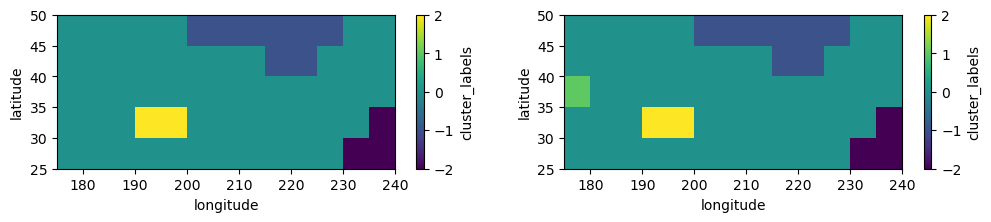

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))

RGDR(
    target_intervals, lag,
    eps_km=600, alpha=0.01, min_area_km2=600**2
).preview_clusters(precursor_field, target_timeseries, ax=ax1, vmin=-2, vmax=2)

RGDR(
    target_intervals, lag,
    eps_km=600, alpha=0.01, min_area_km2=None
).preview_clusters(precursor_field, target_timeseries, ax=ax2, vmin=-2, vmax=2)


Once you are satisfied with the selected parameters, the `.fit` method can be used to fit the RGDR clustering to a precursor field.


In [8]:
rgdr.fit(precursor_field, target_timeseries)

`.transform` can then be used to return the data reduced to clusters.

Note that only the data for the specified precursor interval index (`-4`) is returned:

In [9]:
clustered_data = rgdr.transform(precursor_field)
xr.set_options(display_expand_data=False) # Hide the full data repr
clustered_data

<xarray.DataArray 'sst' (anchor_year: 40, i_interval: 1, cluster_labels: 5)>
292.2 289.7 286.0 292.0 296.1 291.9 ... 296.4 292.6 288.8 285.7 292.2 295.8
Coordinates:
  * anchor_year     (anchor_year) int64 1979 1980 1981 1982 ... 2016 2017 2018
  * i_interval      (i_interval) int64 -4
    left_bound      (anchor_year, i_interval) datetime64[ns] 1979-07-04 ... 2...
    right_bound     (anchor_year, i_interval) datetime64[ns] 1979-07-11 ... 2...
    is_target       (i_interval) bool False
  * cluster_labels  (cluster_labels) int16 -3 -2 -1 1 2
    latitude        (cluster_labels) float64 28.7 37.5 45.58 37.5 32.5
    longitude       (cluster_labels) float64 233.7 232.5 215.4 180.0 195.0
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

Now we can plot the data for each cluster (blue for positively correlated lcusters, red for negatively correlated ones):

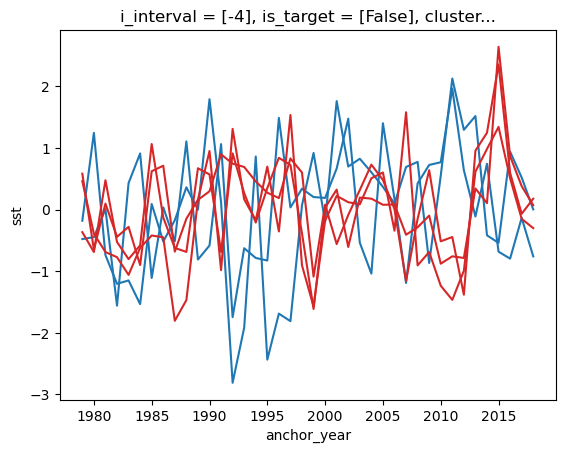

In [10]:
import matplotlib.pyplot as plt
clustered_data = clustered_data  - clustered_data.mean(dim="anchor_year")
kwargs = {'x': 'anchor_year', 'add_legend': False}
clustered_data.sel(cluster_labels=1).plot.line(c='tab:blue', **kwargs)
clustered_data.sel(cluster_labels=2).plot.line(c='tab:blue', **kwargs)
clustered_data.sel(cluster_labels=-1).plot.line(c='tab:red', **kwargs)
clustered_data.sel(cluster_labels=-2).plot.line(c='tab:red', **kwargs)
clustered_data.sel(cluster_labels=-3).plot.line(c='tab:red', **kwargs)

The `RGDR` object will also contain the correlation maps, p-values, and cluster maps.

These are all `xr.DataArray` objects, and can easily be plot using the builtin methods:

In [11]:
# View the contents of the corr_map DataArray:
rgdr.corr_map

<xarray.DataArray (latitude: 5, longitude: 13)>
0.2697 0.2123 0.0529 -0.1931 -0.3189 ... -0.1533 -0.246 -0.3174 -0.4126 -0.4341
Coordinates:
  * latitude    (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * longitude   (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
    area        (latitude) float64 2.088e+05 2.278e+05 ... 2.606e+05 2.741e+05
    cluster     int64 3
    tfreq       int64 ...
    n_clusters  int64 ...

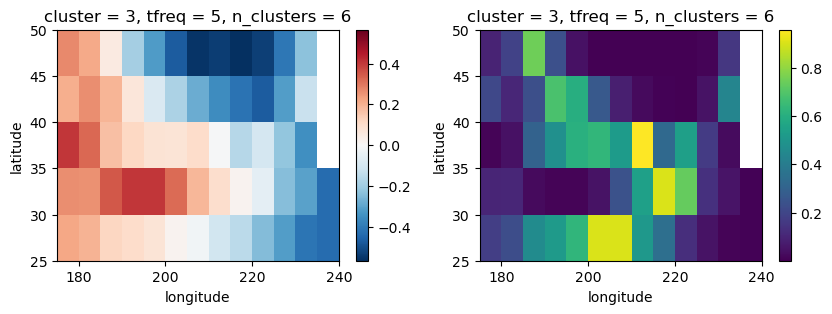

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=2)

# Visualize correlation map after RGDR().fit(precursor_field, target_timeseries)
rgdr.corr_map.plot(ax=ax1)

# Visualize p-values map
rgdr.pval_map.plot(ax=ax2)

The cluster maps can also be visualized:

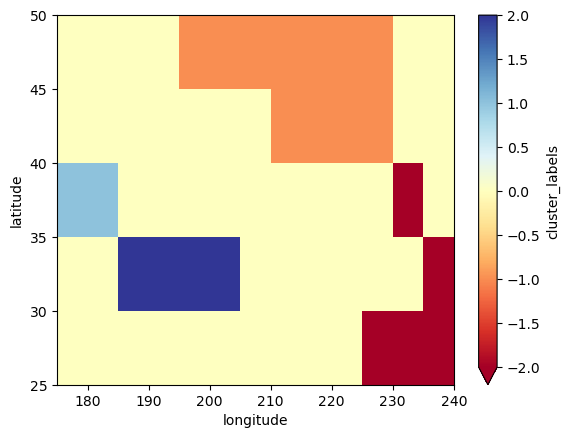

In [13]:
rgdr.cluster_map.plot(cmap='RdYlBu', vmin=-2, vmax=2)

## Multiple target intervals

As mentioned earlier, with RGDR you can also analyse the correlation of multiple intervals at once.

Instead of a simple correlation, this is more akin to a cross-correlation operation.

When you select multiple target intervals, these will be correlated with the same number of precursor intervals, shifted by the `lag` value.

As an illustration, see the image below:

![Multiple Targets](../notebooks/multiple_targets_RGDR.svg)

Now let's see it in action:

In [14]:
target_intervals = [1, 2, 3, 4]
lag = 4
rgdr = RGDR(
    target_intervals=target_intervals,
    lag=lag,
    eps_km=600,
    alpha=0.05,
    min_area_km2=0
)
rgdr.precursor_intervals

[-4, -3, -2, -1]

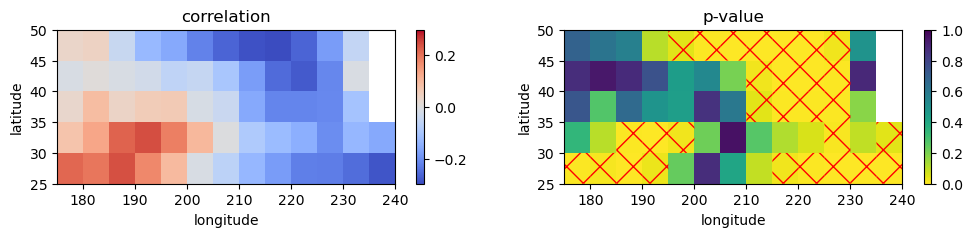

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))
_ = rgdr.preview_correlation(precursor_field, target_timeseries, ax1=ax1, ax2=ax2)
rgdr.fit(precursor_field, target_timeseries)

Note that the transformed data now has all four precursor intervals:

In [16]:
clustered_data = rgdr.transform(precursor_field)
clustered_data

<xarray.DataArray 'sst' (anchor_year: 40, i_interval: 4, cluster_labels: 2)>
289.5 297.3 290.1 297.4 290.7 297.6 ... 289.9 297.8 290.6 297.9 291.1 298.1
Coordinates:
  * anchor_year     (anchor_year) int64 1979 1980 1981 1982 ... 2016 2017 2018
  * i_interval      (i_interval) int64 -4 -3 -2 -1
    left_bound      (anchor_year, i_interval) datetime64[ns] 1979-07-04 ... 2...
    right_bound     (anchor_year, i_interval) datetime64[ns] 1979-07-11 ... 2...
    is_target       (i_interval) bool False False False False
  * cluster_labels  (cluster_labels) int16 -1 1
    latitude        (cluster_labels) float64 38.05 29.58
    longitude       (cluster_labels) float64 221.1 188.1
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...